<a href="https://colab.research.google.com/github/Giorgia3/Data_Spaces_Project/blob/main/Data_Spaces_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Spaces () course project
## Giorgia Ghione (s262606)

Dataset: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records


## Setup

###Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade matplotlib
# !pip uninstall sklearn
# !pip uninstall scikit-learn
# !pip install -U scikit-learn --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import os.path
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
import csv
import numpy as np
import numpy.ma as ma
import scipy
import pandas as pd
from tqdm import tqdm
from enum import Enum
import itertools
import json
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
% matplotlib inline
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns
from linecache import getline
from pathlib import Path
import math
import gc
import subprocess
import shlex
import pickle
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import collections
import torch
import tensorflow as tf
from IPython.display import display, HTML
import os
from imblearn import FunctionSampler 
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import clone
import plotly.express as px
from sklearn import tree, svm, linear_model, ensemble, neighbors
from sklearn.utils.fixes import loguniform

###Configuration

In [4]:
config_dict = {}
config_dict['GENERAL'] = {}
config_dict['GENERAL']['USE_GPU'] = False
config_dict['GENERAL']['RAND_STATE'] = 42

config_dict['DATA'] = {}
config_dict['DATA']['INPUT_DATASET_FILENAME'] = 'heart_failure_clinical_records_dataset.csv'
config_dict['DATA']['TARGET_COL'] = 'DEATH_EVENT'
config_dict['DATA']['NUMERIC_COLS'] = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', "serum_creatinine", 'serum_sodium', 'time']
config_dict['DATA']['BOOLEAN_COLS'] = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', "smoking"]

config_dict['CROSSVAL'] = {}
config_dict['CROSSVAL']['K_OUTER'] = 10
config_dict['CROSSVAL']['K_INNER'] = 5

config_dict['CLASSIFICATION'] = {}
config_dict['CLASSIFICATION']['MODELS'] = {
    'DecisionTree': tree.DecisionTreeClassifier(),
    'SVC': svm.SVC(),
    'LogisticRegression': linear_model.LogisticRegression(),
    'RandomForest': ensemble.RandomForestClassifier(),
    'KNN': neighbors.KNeighborsClassifier()
}
config_dict['CLASSIFICATION']['PARAMS'] = {
    'KNN': {
            'KNN__n_neighbors' : list(range(1,35, 4)), #1+4n is always odd
            'KNN__weights': ['uniform', 'distance' ],
            'KNN__n_jobs' : [-1],
            },
    'SVC': {
            'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  #list(loguniform(1e-3, 1e3)),
            'SVC__gamma': [0.001, 0.01, 0.1, 1],     #list(loguniform(1e-3, 1)),
            'SVC__kernel': ['rbf', 'poly', 'linear'],
            'SVC__random_state': [config_dict['GENERAL']['RAND_STATE']],
            },
    'LogisticRegression': {
            'LogisticRegression__penalty': ['l1', 'l2'],
            'LogisticRegression__random_state': [config_dict['GENERAL']['RAND_STATE']],
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   #list(loguniform(1e-3, 1e3)),
            'LogisticRegression__max_iter': [1000],
            'LogisticRegression__solver': ['liblinear'],
            },
    'DecisionTree': {
            'DecisionTree__max_depth': list(range(2, 10)),
            'DecisionTree__min_samples_split': list(range(2, 10)),
            'DecisionTree__criterion' : ['gini', 'entropy'],
            'DecisionTree__random_state': [config_dict['GENERAL']['RAND_STATE']],
            },
    'RandomForest': {
            'RandomForest__n_estimators': [10, 100],
            'RandomForest__criterion' : ['gini', 'entropy'],
            'RandomForest__random_state': [config_dict['GENERAL']['RAND_STATE']],
            'RandomForest__max_depth': list(range(2, 10)),
            'RandomForest__min_samples_split': [2, 5, 10], #list(range(2, 10)),
            'RandomForest__max_features': ['sqrt'],
            'RandomForest__n_jobs' : [-1],
            },
}

config_dict['CLASSIFICATION']['BALANCERS'] = { # categorical_features indices list to be set later!
    'SMOTENC' : SMOTENC(categorical_features=None, random_state=config_dict['GENERAL']['RAND_STATE'], sampling_strategy='not majority', n_jobs=-1)
} 

config_dict['CLASSIFICATION']['SCALERS'] = {
    'StandardScaler' : ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), config_dict['DATA']['NUMERIC_COLS']),
            ])
}

In [5]:
def generate_config_str():
    str_conf = '--------------------------------------------------------------\n'
    str_conf += "Configuration:\n"
    str_conf += "==============\n"
    str_conf += '\n'
    for key, value in config_dict.items():
        str_conf += f"\t{key} = {str(value)}\n"
    str_conf += '\n'
    str_conf += '--------------------------------------------------------------'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    return str_conf

In [6]:
if config_dict['GENERAL']['USE_GPU']:
    # Get the GPU device name.
    device_name = tf.test.gpu_device_name()

    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

# elif USE_TPU:
#     try:
#         tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#         print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#     except ValueError:
#         raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

else:
    print('Runtime type: None.')

Runtime type: None.


In [7]:
class_colors = ['C2', 'C3']

### Directories and files

In [8]:
main_dir = '/content/drive/My Drive/DS_project'

# Input data:
datasets_dir = Path(main_dir) / 'datasets'
original_dataset_dir = Path(datasets_dir) / 'original'
original_dataset_file = original_dataset_dir / config_dict['DATA']['INPUT_DATASET_FILENAME']
if not os.path.exists(original_dataset_file):
    raise FileNotFoundError(f"File {original_dataset_file} not found")

#preprocessed data
preprocessed_data_dir = Path(datasets_dir) / 'preprocessed'
if not os.path.exists(preprocessed_data_dir):
    os.makedirs(preprocessed_data_dir)
    print(f"Directory '{preprocessed_data_dir}' created")


# train val test
trainvaltest_splits_dir = Path(preprocessed_data_dir) / 'trainvaltest_splits'
if not os.path.exists(trainvaltest_splits_dir):
    os.makedirs(trainvaltest_splits_dir)
    print(f"Directory '{trainvaltest_splits_dir}' created")
train_file = Path(trainvaltest_splits_dir) / 'train.csv'
val_file = Path(trainvaltest_splits_dir) / 'val.csv'
test_file = Path(trainvaltest_splits_dir) / 'test.csv'

# outputs
outputs_dir = Path(main_dir) / 'outputs'
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)
    print(f"Directory '{outputs_dir}' created")

log_dir = Path(outputs_dir) / 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print(f"Directory '{log_dir}' created")

EDA_dir = Path(outputs_dir) / 'EDA'
if not os.path.exists(EDA_dir):
    os.makedirs(EDA_dir)
    print(f"Directory '{EDA_dir}' created")
boxplots_dir = Path(outputs_dir) / 'boxplots'
if not os.path.exists(boxplots_dir):
    os.makedirs(boxplots_dir)
    print(f"Directory '{boxplots_dir}' created")

classification_dir = Path(outputs_dir) / 'classification'
if not os.path.exists(classification_dir):
    os.makedirs(classification_dir)
    print(f"Directory '{classification_dir}' created")
confusion_matr_dir = Path(outputs_dir) / 'confusion_matr'
if not os.path.exists(confusion_matr_dir):
    os.makedirs(confusion_matr_dir)
    print(f"Directory '{confusion_matr_dir}' created")
PCA_classification_dir = Path(classification_dir) / 'classification'
if not os.path.exists(PCA_classification_dir):
    os.makedirs(PCA_classification_dir)
    print(f"Directory '{PCA_classification_dir}' created")

In [9]:
n_log_files = len(os.listdir(log_dir))
if n_log_files > 0:
    log_file = Path(log_dir) / f'log({n_log_files}).txt'
else:
    log_file = Path(log_dir) / f'log.txt'

with open(log_file, 'w') as log_fp:
    log_fp.write(generate_config_str())
    print(generate_config_str())

--------------------------------------------------------------
Configuration:

	GENERAL = {'USE_GPU': False, 'RAND_STATE': 42}
	DATA = {'INPUT_DATASET_FILENAME': 'heart_failure_clinical_records_dataset.csv', 'TARGET_COL': 'DEATH_EVENT', 'NUMERIC_COLS': ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time'], 'BOOLEAN_COLS': ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']}
	CROSSVAL = {'K_OUTER': 10, 'K_INNER': 5}
	CLASSIFICATION = {'MODELS': {'DecisionTree': DecisionTreeClassifier(), 'SVC': SVC(), 'LogisticRegression': LogisticRegression(), 'RandomForest': RandomForestClassifier(), 'KNN': KNeighborsClassifier()}, 'PARAMS': {'KNN': {'KNN__n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33], 'KNN__weights': ['uniform', 'distance'], 'KNN__n_jobs': [-1]}, 'SVC': {'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'SVC__gamma': [0.001, 0.01, 0.1, 1], 'SVC__kernel': ['rbf', 'poly', 'linear'], 'SVC__random_state': [42]}, 'Log

## Dataset description

Import dataset

In [10]:
with open(original_dataset_file) as in_fp:
    original_df = pd.read_csv(in_fp, sep=',', header=0)
    print(display(original_df.head()))
    print(f'N. samples = {original_df.shape[0]} | N. features = {original_df.shape[1]}')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


None
N. samples = 299 | N. features = 13


###Missing values





In [11]:
print("Number of missing values per column:")
print(original_df.isna().sum())

Number of missing values per column:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### Class counts

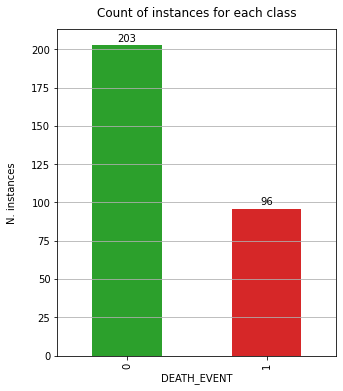

In [12]:
xticks = [idx[0] for idx in original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().index]
ax = original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().plot.bar(xticks = xticks, color=class_colors, figsize=(5,6))
plt.ylabel("N. instances", labelpad=14)
plt.title("Count of instances for each class", y=1.02);
plt.grid(axis='y')
for i,p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 1, original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']].value_counts().to_numpy()[i], ha="center", va="bottom")
plt.show()

### Training and test dataset splits

In [13]:
X = original_df.loc[:, original_df.columns != config_dict['DATA']['TARGET_COL']]
y = original_df.loc[:, original_df.columns == config_dict['DATA']['TARGET_COL']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)
print(f'Training dataset length: {X_train.shape[0]}')
print(f'Test dataset length: {X_test.shape[0]}')

Training dataset length: 239
Test dataset length: 60


## Exploratory Data Analysis (EDA)

### Statistical quantitative description of features

In [14]:
boolean_attributes = config_dict['DATA']['BOOLEAN_COLS']
numeric_attributes = config_dict['DATA']['NUMERIC_COLS']
print(display(X_train[numeric_attributes].describe()))

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,61.072527,602.790795,37.887029,263670.546444,1.391715,136.527197,127.217573
std,11.443865,1012.362885,11.994738,99410.331023,1.089060,4.425657,77.575734
min,40.000000,23.000000,15.000000,25100.000000,0.500000,113.000000,4.000000
25%,51.500000,117.000000,30.000000,212500.000000,0.900000,134.000000,69.500000
50%,60.000000,253.000000,38.000000,263358.030000,1.100000,137.000000,112.000000
75%,69.500000,582.000000,45.000000,303500.000000,1.400000,139.000000,197.500000
max,95.000000,7861.000000,80.000000,850000.000000,9.400000,148.000000,280.000000


None


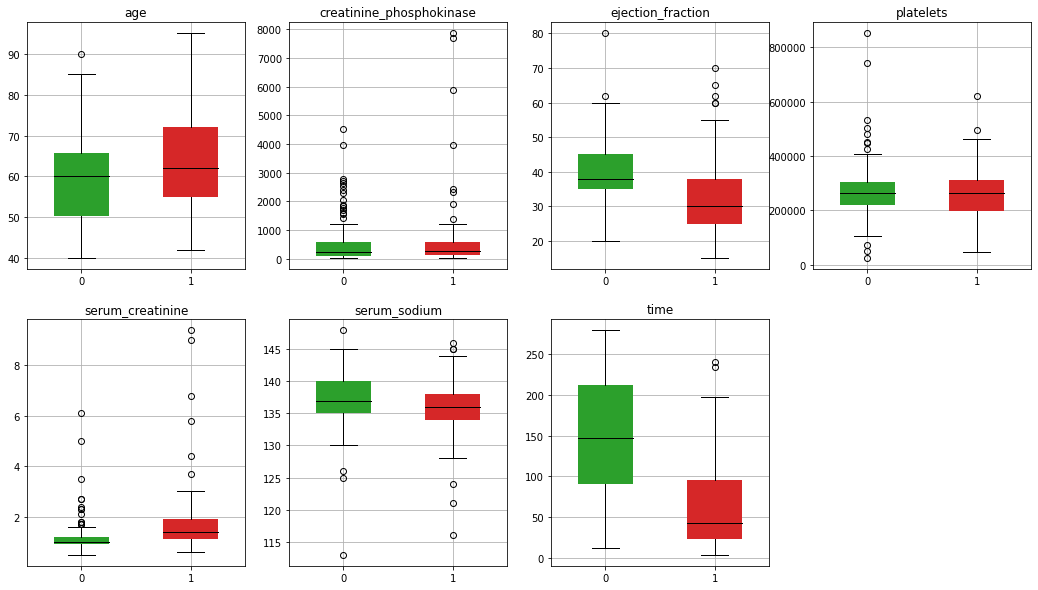

In [15]:
def box_plot(data, labels, ax):
    bp = ax.boxplot(data, labels=labels, widths=0.5, patch_artist=True)
    for patch, color in zip(bp['boxes'], class_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('None')
    for median in bp['medians']:
        median.set_color('black')
    ax.grid()

fig1, ax1 = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
target_col = config_dict['DATA']['TARGET_COL']
for col, ax in zip(numeric_attributes, ax1.ravel()):
    ax.set_title(f"{col}")
    per_class_df_list = [X_train[y_train[target_col]==0][col], X_train[y_train[target_col]==1][col]]
    box_plot(per_class_df_list, labels=[0,1], ax=ax)

fig1.delaxes(ax1[1][3])
fig_path = Path(boxplots_dir) / f'{col}.jpg'
fig1.savefig(fig_path, bbox_inches='tight')
plt.show()
fig1.clear()

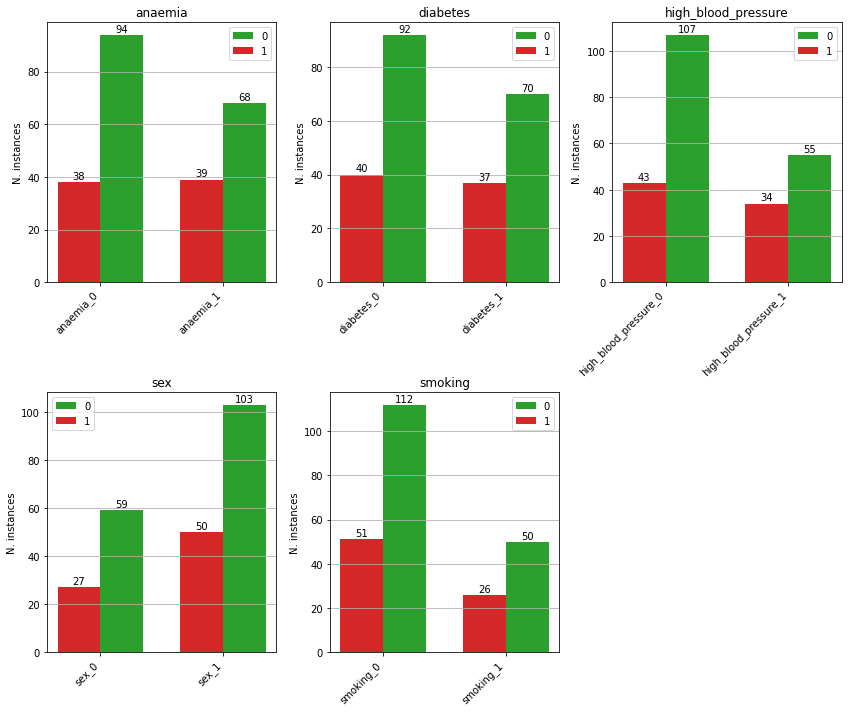

In [16]:
fig1, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
target_col = config_dict['DATA']['TARGET_COL']

for col, ax in zip(boolean_attributes, ax1.ravel()):

    var_labels = []
    class_1_var_counts = []
    class_0_var_counts = []

    for var_value in [0,1]:
        var_labels.append(f'{col}_{var_value}')
        class_1_var_counts.append(X_train.loc[y_train[target_col]==1].loc[X_train[col]==var_value][col].count())
        class_0_var_counts.append(X_train.loc[y_train[target_col]==0].loc[X_train[col]==var_value][col].count())

    x = np.arange(len(var_labels))  # the label locations
    width = 0.35  # the width of the bars

    rects2 = ax.bar(x + width/2, class_0_var_counts, width, label='0', color=class_colors[0])
    rects1 = ax.bar(x - width/2, class_1_var_counts, width, label='1', color=class_colors[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('N. instances')
    ax.set_title(col)
    ax.set_xticks(x, var_labels, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis='y')

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)

fig1.tight_layout()
fig1.delaxes(ax1[1][2])
plt.show()
fig1.clear()

### Correlation analysis


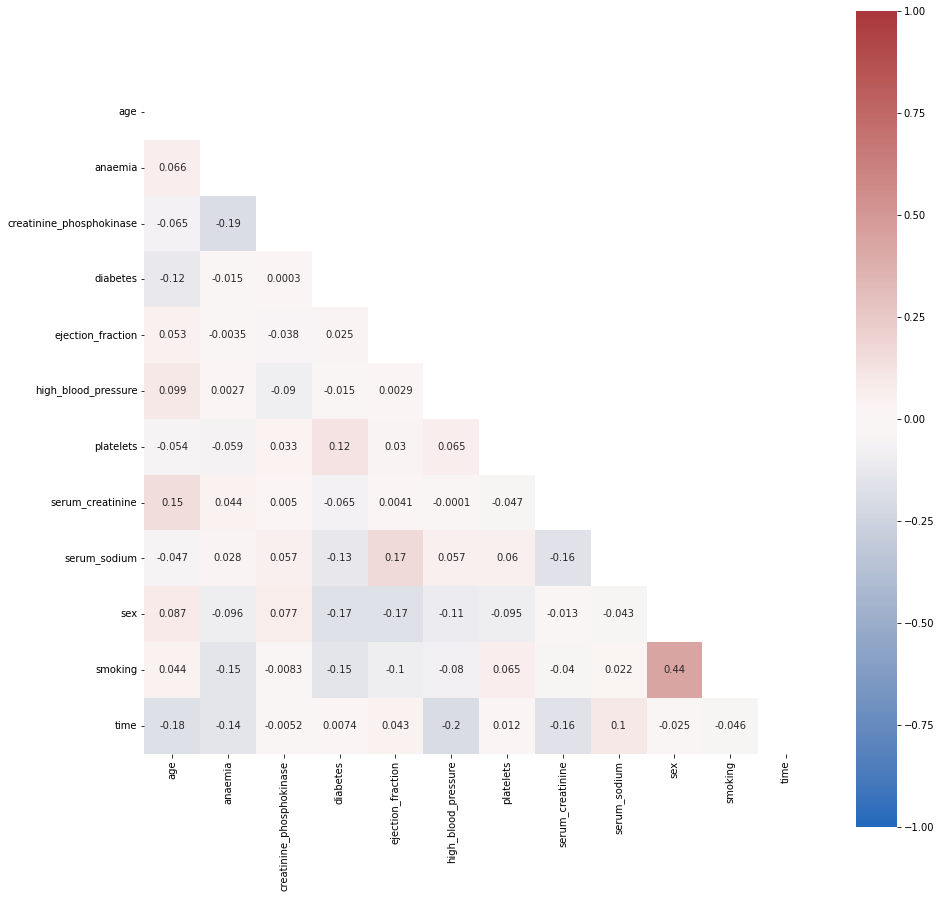

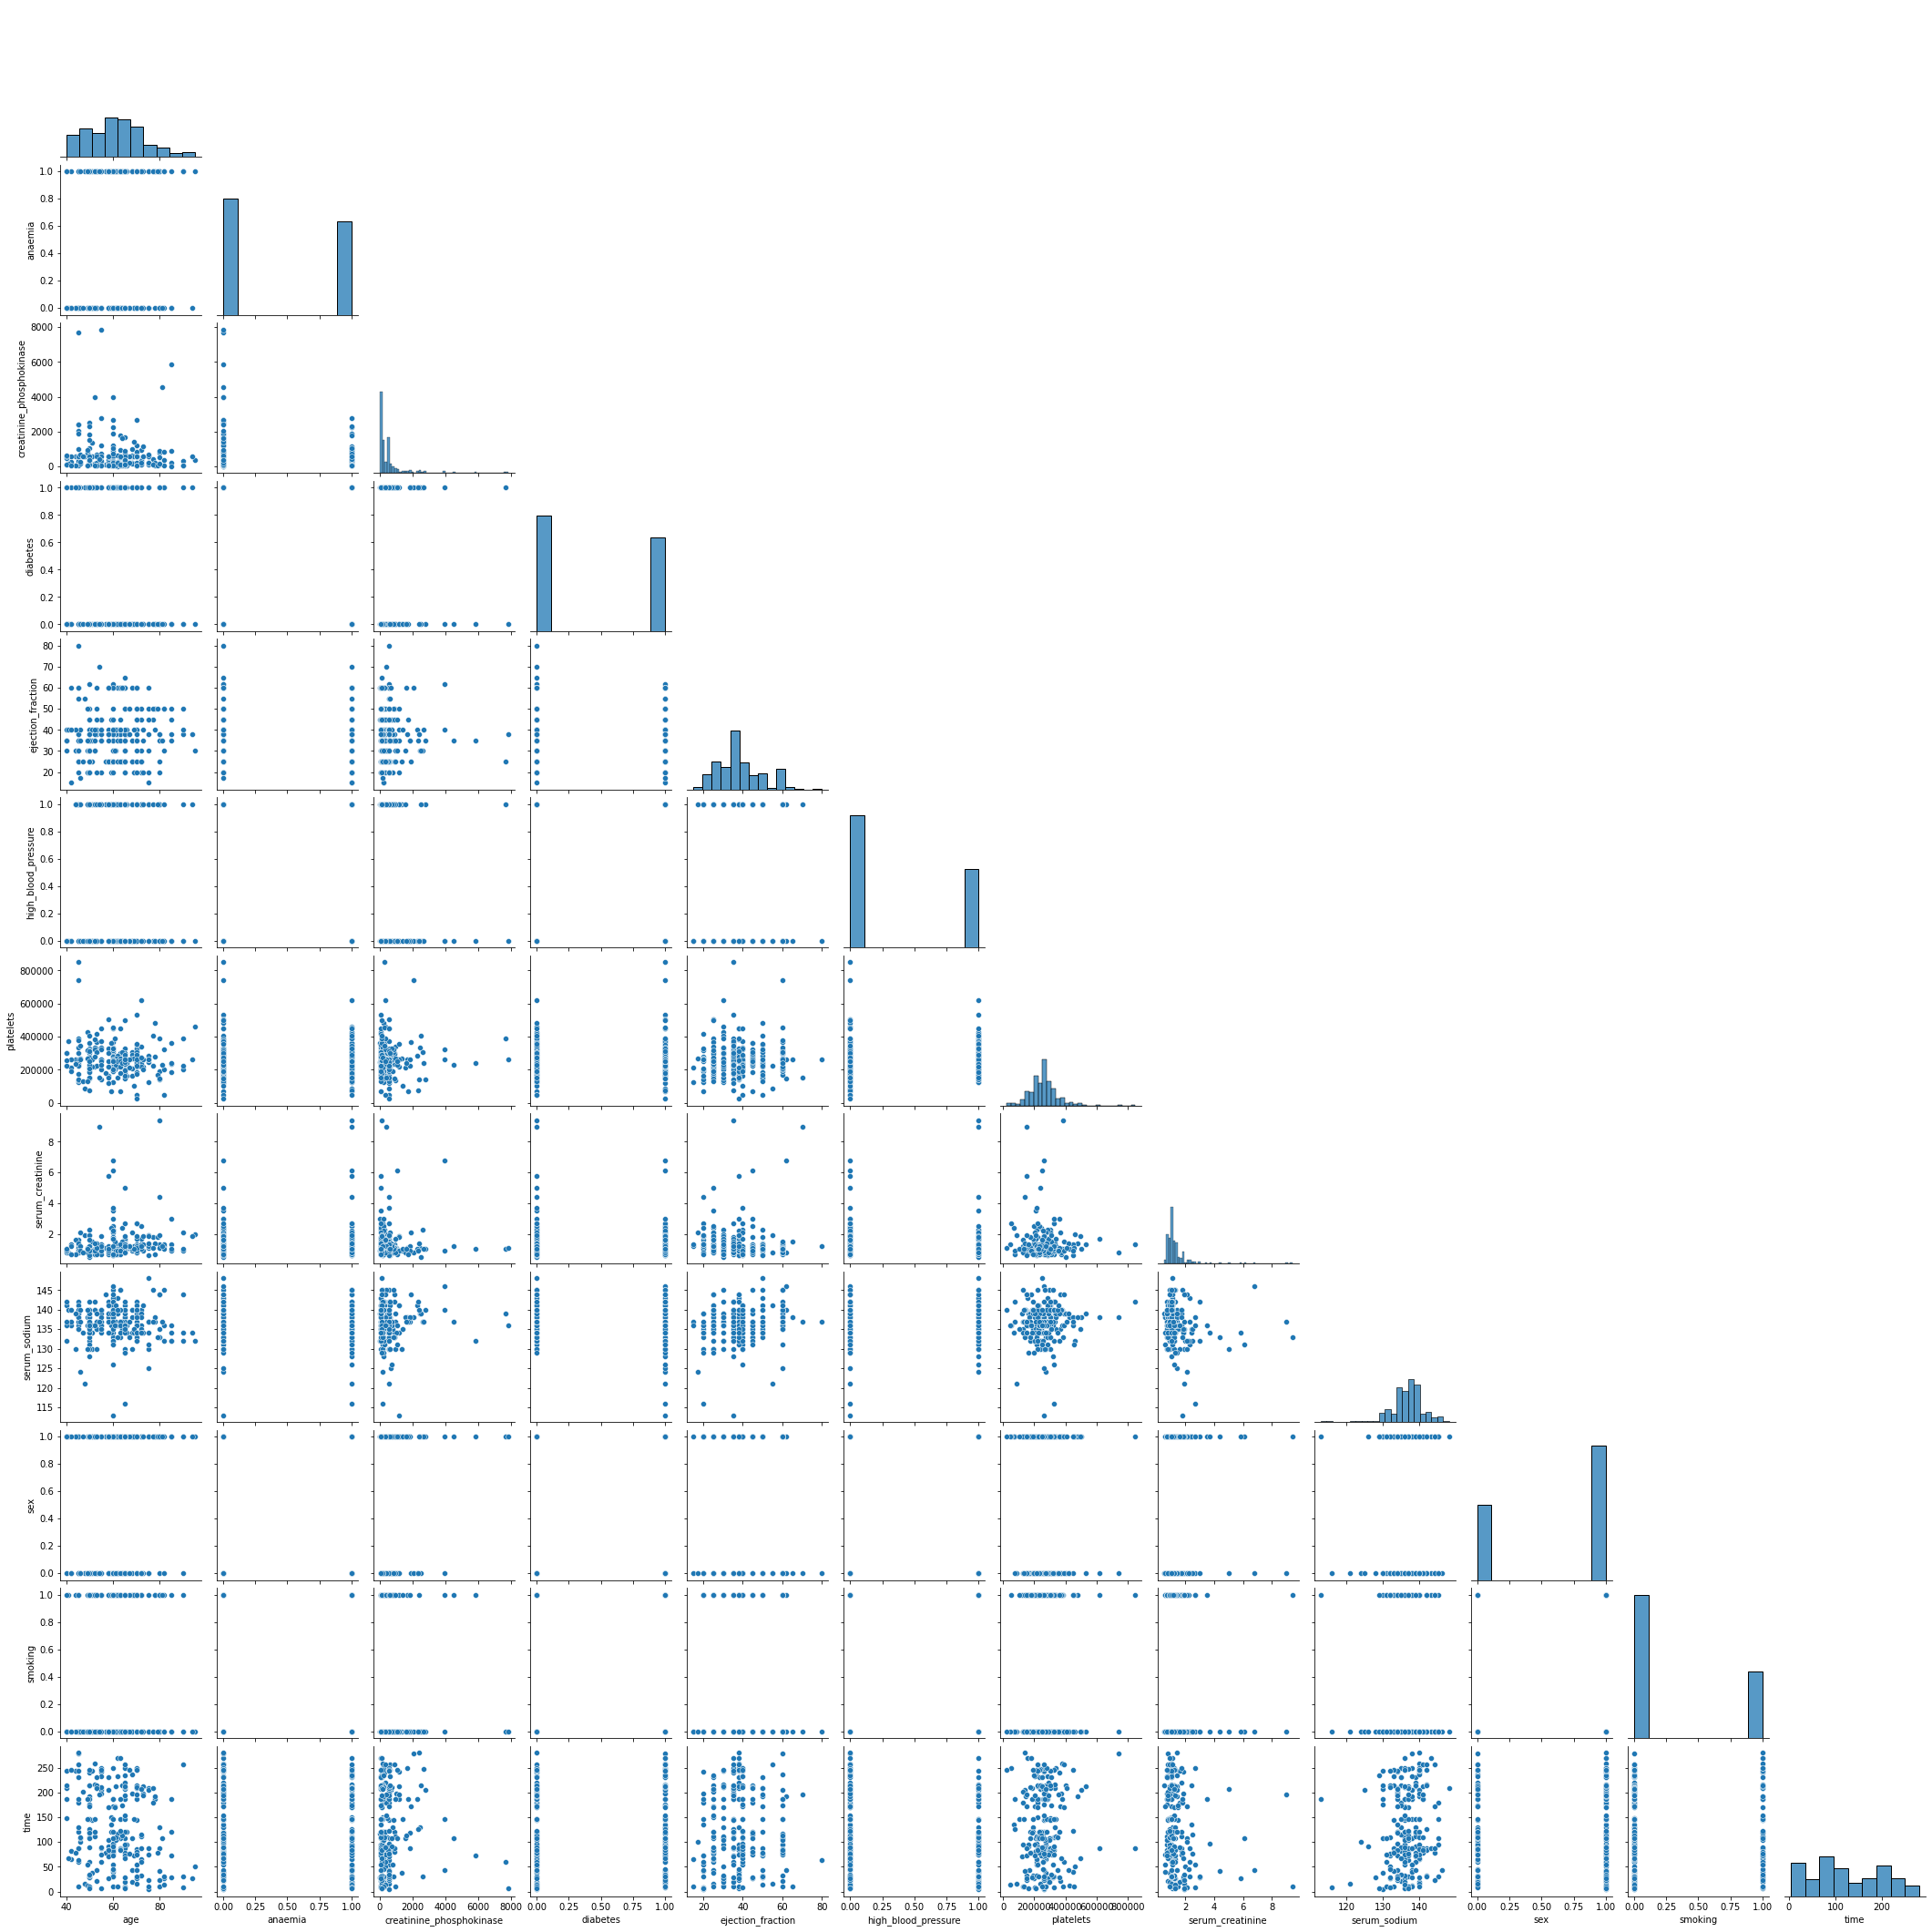

In [17]:
corr_mat = X_train.corr()
mask_upper = np.triu(np.ones_like(corr_mat, dtype=bool))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask_upper, ax=ax, square=True)
sns.pairplot(X_train, corner=True)
plt.show()

## PCA

In [18]:
def plot_PCA_explained_variance(pca, filepath):
    fig = plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
    plt.plot(pca.explained_variance_ratio_, label="Normal")
    plt.legend()
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    fig.savefig(filepath)

def plot_PCA_biplot(pca, components, X, y, filepath):
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    fig = px.scatter(components, x=0, y=1, color=y.values.ravel())

    for i, feature in enumerate(X.columns):
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=loadings[i, 0],
            y1=loadings[i, 1]
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
        )
    fig.show()
    
def PCA_exp_var_analysis(X, y):
    pca = PCA(n_components=len(X.columns), random_state=config_dict['GENERAL']['RAND_STATE'])
    scaler = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ("standardscaler", StandardScaler(), numeric_attributes),
        ]
    )
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    plot_PCA_explained_variance(pca, Path(PCA_classification_dir) / f'explained_variance.jpg')
    plot_PCA_biplot(pca, pca_components, X, y, Path(PCA_classification_dir) / f'biplot.jpg')

## Classification

### Plots functions

In [19]:
def print_classification_report(y, y_pred, title='Classification report:'):
    print(f"\n{title}")
    # print(metrics.classification_report(y, y_pred))
    display(pd.DataFrame.from_dict(metrics.classification_report(y, y_pred, output_dict=True)).T)

def plot_confusion_matrix(model, X, y, filepath, title='Confusion matrix'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(title)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax)
    fig.savefig(filepath)

def plot_PRC(y, y_pred, name, filepath, title):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title(title)
    metrics.PrecisionRecallDisplay.from_predictions(y, y_pred, name=name, ax=ax)
    fig.show()
    fig.savefig(filepath)

def plot_decision_boundary(X, y, classifier, noise=False):
    n_classes = 2
    labels = [f"{config_dict['DATA']['TARGET_COL']}=FALSE", f"{config_dict['DATA']['TARGET_COL']}=TRUE"]
    plot_colors = ["red", "green"]

    plot_step = 0.02

    # # X = X[:,:3]
    # x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    # y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # plt.figure(2, figsize=(8, 6))
    # plt.clf()

    # # Plot the training points
    # plt.scatter(X[:, 0], X[:, 1], c=y.values.ravel(), cmap=plt.cm.Set1, edgecolor="k")

    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    # plt.xticks(())
    # plt.yticks(())

    # # To getter a better understanding of interaction of the dimensions
    # # plot the first three PCA dimensions
    # fig = plt.figure(1, figsize=(8, 6))
    # ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)


    # ax.scatter(
    #     X[:, 0],
    #     X[:, 1],
    #     X[:, 2],
    #     c=y.values.ravel(),
    #     cmap=plt.cm.Set1,
    #     edgecolor="k",
    # )

    # ax.set_title("First three PCA directions")
    # ax.set_xlabel("1st eigenvector")
    # ax.w_xaxis.set_ticklabels([])
    # ax.set_ylabel("2nd eigenvector")
    # ax.w_yaxis.set_ticklabels([])
    # ax.set_zlabel("3rd eigenvector")
    # ax.w_zaxis.set_ticklabels([])

    # plt.show()

    for pairidx, pair in enumerate(list(itertools.combinations(range(X.shape[1]),2))):
        _X = X[:, list(pair)]
        print(_X.shape)
        clf = classifier.fit(_X, y)
        selected_features = pair

        # Plot the decision boundary
        plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = _X[:, 0].min() - 1, _X[:, 0].max() + 1
        y_min, y_max = _X[:, 1].min() - 1, _X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z[0,0]=1 #prevent the color map to collapse when the model did overfit
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(selected_features[0])
        plt.ylabel(selected_features[1])

        # Plot the training points
        if noise:
            _noise = np.random.normal(0, .05, _X.shape)
            _X = _X + _noise
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(
                _X[idx, 0],
                _X[idx, 1],
                c=color,
                label=labels[i],
                cmap=plt.cm.RdYlBu,
                edgecolor="black",
                s=15,
            )


    plt.suptitle(f"Decision surface of {type(classifier).__name__} + PCA on the PC1-PC2 plane")
    # plt.legend(loc="lower right", borderpad=0, handletextpad=0)
    plt.axis("tight")
    plt.show()



### The cross-validation process

In [20]:
class ClassificationProcessor():

    def __init__(self, classifiers):
        self.__best_classifier = None
        self.__classifiers = classifiers

    def find_best_model(self, X_train, y_train):
        best_classifier = None
        best_score = 0

        for classifier in classifiers:
            global_test_score, global_test_std = classifier.nested_CV(X_train, y_train)
            if global_test_score > best_score:
                best_score = global_test_score
                best_classifier = classifier
                
        self.__best_classifier = best_classifier
        print(f'\nBEST CLASSIFIER: {self.__best_classifier.name} (F1-score={best_score})')

        
    def __models_fit_predict(self, X_train, y_train, X_test, y_test, compare_all_classifiers=False, apply_PCA=False, n_components=None):
        # simple cross validation to train the best model:
        print('>> Simple cross validation to train the best model...')

        if compare_all_classifiers:
            list_classifiers = self.__classifiers
        else:
            list_classifiers = [self.__best_classifier]

        if apply_PCA:
            pca = PCA(n_components=n_components, random_state=config_dict['GENERAL']['RAND_STATE'])
            scaler = ColumnTransformer(
                remainder='passthrough',
                transformers=[
                    ("standardscaler", StandardScaler(), numeric_attributes),
                ]
            )
            X_scaled = scaler.fit_transform(X_train)
            pca.fit(X_scaled)
            print(f'Cumulative explained variance for {pca.n_components_} principal components: {np.sum(pca.explained_variance_ratio_)}')

        # plot PRC
        fig_prc = plt.figure()
        ax = fig_prc.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.grid(True)
        ax.set_aspect('equal')
        ax.legend(loc='lower right')
        ax.set_title("Precision-Recall curves on the test dataset")

        cv = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_INNER'], shuffle=True, random_state=config_dict['GENERAL']['RAND_STATE'])

        for classifier in list_classifiers:
            classifier.simple_CV(cv, X_train, y_train, X_test, y_test, ax, apply_PCA=apply_PCA, n_components=n_components)
   
        # plot PRC
        fig_prc.show()
        fig_prc.savefig(Path(classification_dir) / f'prc.jpg')

    
    def test_best_model(self, X_train, y_train, X_test, y_test):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=False, apply_PCA=False, n_components=None)

    def test_best_model_PCA(self, X_train, y_train, X_test, y_test, n_components):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=False, apply_PCA=True, n_components=n_components)

    def compare_models(self, X_train, y_train, X_test, y_test):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=True, apply_PCA=False, n_components=None)

    def compare_models_PCA(self, X_train, y_train, X_test, y_test, n_components):
        self.__models_fit_predict(X_train, y_train, X_test, y_test, compare_all_classifiers=True, apply_PCA=True, n_components=n_components)


class Classifier():

    def __init__(self, name, model, grid, class_balancer, feature_scaler):
        self.name = name
        self.model = model
        self.grid = grid
        self.class_balancer = class_balancer
        self.feature_scaler = feature_scaler
        
        self.pipeline = Pipeline([
            ('feature_scaler', feature_scaler), 
            ('classbalancer', self.class_balancer), 
            (self.name, self.model)])


    def nested_CV(self, X_train, y_train):
        test_outer_results = []
        train_outer_results = []
        best_hyperparams = []

        cv_outer = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_OUTER'], shuffle=True, random_state=config_dict['GENERAL']['RAND_STATE'])

        # nested cross validation for unbiased error estimation:
        print("\n===================================================================")
        print(f"\t\t\t{self.name}")
        print("===================================================================\n")
        print(">> Nested cross validation for unbiased error estimation...")
        for train_ix, test_ix in cv_outer.split(X_train, y_train):

            # split data in k_outer folds (one is test, the rest is trainval) for outer loop
            X_train_cv, X_test_cv = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
            y_train_cv, y_test_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]

            # inner cross validation procedure for grid search of best hyperparameters:
            # trainval will be split in k_inner folds (one is val, the rest is train)
            # use train and val to find best model
            cv_inner = StratifiedKFold(n_splits=config_dict['CROSSVAL']['K_INNER'], shuffle=True,
                                random_state=config_dict['GENERAL']['RAND_STATE'])
            # search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.grid, n_iter=20, cv=cv_inner, n_jobs=-1,
            #                         scoring='f1', refit=True, verbose=2)
            search = GridSearchCV(estimator=self.pipeline, param_grid=self.grid, cv=cv_inner, n_jobs=-1,
                                    scoring='f1', refit=True, verbose=0)

            # outer cross validation procedure to evaluate the performance of the best estimator:
            # fit the best model on the whole trainval
            search.fit(X_train_cv, y_train_cv.values.ravel())
            best_model = search.best_estimator_
            best_score = search.best_score_
            best_param = search.best_params_

            # evaluate the performance of the model on test
            y_test_pred = search.predict(X_test_cv)
            test_score = metrics.f1_score(y_test_cv, y_test_pred)
            y_train_pred = search.predict(X_train_cv)
            train_score = metrics.f1_score(y_train_cv, y_train_pred)

            test_outer_results.append(test_score)
            train_outer_results.append(train_score)
            best_hyperparams.append(search.best_params_)

            print('\n__________________________________________________________\n')
            print(f"Inner CV: ")
            print(f"    Best F1-score of positive class = {best_score}")
            print(f"Outer CV: ")
            print(f"    Val F1-score of positive class = {test_score}")
            # print_classification_report(y_test_cv, y_test_pred, "Outer CV Val classification report")
            # print_classification_report(y_train_cv, y_train_pred, "Outer CV Train classification report")

        # calculate the mean score over all K outer folds, and report as the generalization error
        global_test_score = np.mean(test_outer_results)
        global_test_std = np.std(test_outer_results)
        global_train_score = np.mean(train_outer_results)
        global_train_std = np.std(train_outer_results)

        print('\n__________________________________________________________\n')
        print(f"Mean validation F1-score of positive class = {str(global_test_score)} ({str(global_test_std)})")
        print(f"Mean training F1-score of positive class = {str(global_train_score)} ({str(global_train_std)})")
        print("List of best hyperparameters to check stability: ")
        best_hyperparams_dict = {}
        for best_hyps in best_hyperparams:
            for k,v in best_hyps.items():
                if k not in best_hyperparams_dict:
                    best_hyperparams_dict[k] = [v]
                else:
                    best_hyperparams_dict[k].append(v)
        print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

        return global_test_score, global_test_std


    def simple_CV(self, cv, X_train, y_train, X_test, y_test, prc_ax, apply_PCA=False, n_components=None):

        print("\n===================================================================")
        print(f"\t\t\t{self.name} {'+ PCA' if apply_PCA else ''}")
        print("===================================================================\n")

        pipeline = None
        if apply_PCA:
            pipeline = Pipeline([
                ('feature_scaler', self.feature_scaler), 
                ('classbalancer', self.class_balancer),
                ('pca', PCA(n_components=n_components, random_state=config_dict['GENERAL']['RAND_STATE'])), 
                (self.name, self.model)
                ])
        else:
            pipeline = self.pipeline

        # search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.grid, n_iter=20, cv=cv, n_jobs=-1,
        #                 scoring='f1', refit=True, verbose=2) 

        search = GridSearchCV(estimator=pipeline, param_grid=self.grid, cv=cv, n_jobs=-1,
                                scoring='f1', refit=True, verbose=0)

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_hyperparam = search.best_params_
        best_score = search.best_score_

        print('>> Predicting on test dataset...')
        y_pred = search.predict(X_test)
        print_classification_report(y_test, y_pred, "Test classification report")

        metrics.PrecisionRecallDisplay.from_predictions(y_test, y_pred, name=self.name, ax=prc_ax)

        # plot confusion matrix
        plot_confusion_matrix(best_model, X_test, y_test, Path(confusion_matr_dir) / f"confusion_matrix_{self.name}{'_PCA' if apply_PCA else ''}.jpg", f"Confusion matrix with {self.name}{' + PCA' if apply_PCA else ''}")

        if apply_PCA:
            # first_components = search.best_estimator_.named_steps['pca'].components_[:3]
            X_test_scaled = best_model.named_steps['feature_scaler'].transform(X_test)
            X_test_pca = best_model.named_steps['pca'].transform(X_test)[:3]
            plot_decision_boundary(X_test_pca, y_test, best_model.named_steps[self.name])

### Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


>> Simple cross validation to train the best model...
Cumulative explained variance for 7 principal components: 0.8662950342807428

			DecisionTree + PCA

>> Predicting on test dataset...

Test classification report


,precision,recall,f1-score,support
0,0.775510,0.926829,0.844444,41.000000
1,0.727273,0.421053,0.533333,19.000000
accuracy,0.766667,0.766667,0.766667,0.766667
macro avg,0.751391,0.673941,0.688889,60.000000
weighted avg,0.760235,0.766667,0.745926,60.000000


(3, 2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but PCA was fitted without feature names



ValueError: ignored

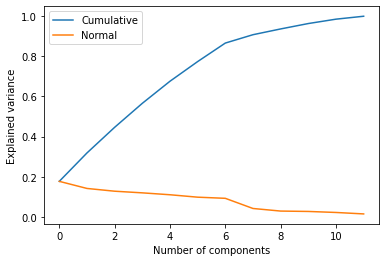

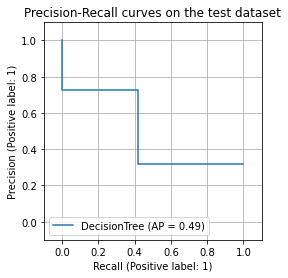

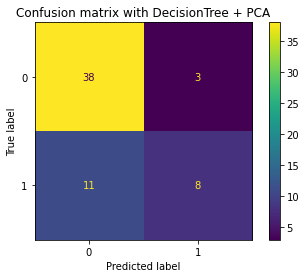

In [27]:
# Standardizing features by removing the mean and scaling to unit variance:
# z = (x - u) / s
feature_scaler = config_dict['CLASSIFICATION']['SCALERS']['StandardScaler']
# class rebalancing
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # done just to retreive the categorical features indices (modified by the scaler)
class_balancer = config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']])

classifiers = []

for classifier_name, classifier_model in config_dict['CLASSIFICATION']['MODELS'].items():
    # if classifier_name == "RandomForest":
    classifiers.append(Classifier(classifier_name, classifier_model, config_dict['CLASSIFICATION']['PARAMS'][classifier_name], class_balancer, feature_scaler))

clf_processor = ClassificationProcessor(classifiers)
# clf_processor.find_best_model(X_train, y_train)
# clf_processor.compare_models(X_train, y_train, X_test, y_test)
PCA_exp_var_analysis(X_train, y_train)
best_n_components = 7
clf_processor.compare_models_PCA(X_train, y_train, X_test, y_test, n_components=best_n_components)

## SMOTE-NC visualization

In [23]:
def plot_resampling(X, y, sampler, ax, title=None, ax_labels=None):
    features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in features_to_display]
    X_res, y_res = sampler.fit_resample(X, y)
    X_res = X_res[:,features_to_display_idx]
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res.values.ravel(), alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    if ax_labels is not None:
        ax.set_xlabel(ax_labels[0])
        ax.set_ylabel(ax_labels[1])
    sns.despine(ax=ax, offset=10)

def compare_rebalancing_techniques(samplers, X, y, ax_labels=None):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    for ax, sampler in zip(axs.ravel(), samplers):
        title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
        plot_resampling(X, y, sampler, ax, title=title, ax_labels=ax_labels)
    fig.tight_layout()

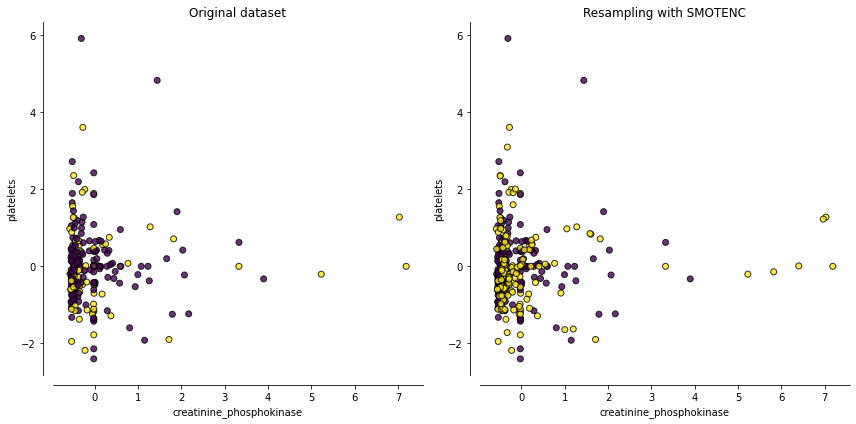

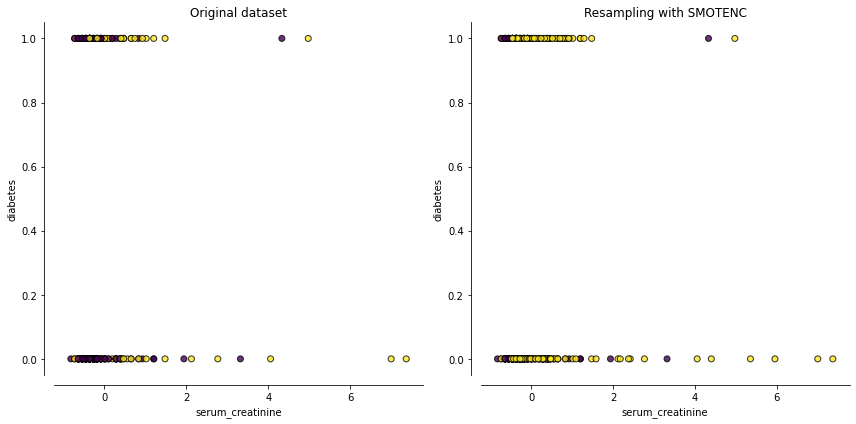

In [24]:
feature_scaler.set_params(verbose_feature_names_out=False)
X_train_scaled = feature_scaler.fit_transform(X_train)

# visualize augmentation in a pair plot with a categorical feature
features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in ['platelets', 'creatinine_phosphokinase']]
features_to_display = feature_scaler.get_feature_names_out()[features_to_display_idx]
samplers = [
    FunctionSampler(), # no rebalancing
    # RandomOverSampler(random_state=0),
    config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']]),
]
compare_rebalancing_techniques(samplers, X_train_scaled, y_train, ax_labels=features_to_display)

# visualize augmentation in a pair plot with two numeric features
features_to_display_idx = [i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in ['diabetes', 'serum_creatinine']]
features_to_display = feature_scaler.get_feature_names_out()[features_to_display_idx]
samplers = [
    FunctionSampler(), # no rebalancing
    # RandomOverSampler(random_state=0),
    config_dict['CLASSIFICATION']['BALANCERS']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler.get_feature_names_out()) if f in config_dict['DATA']['BOOLEAN_COLS']]),
]
compare_rebalancing_techniques(samplers, X_train_scaled, y_train, ax_labels=features_to_display)

In [25]:
feature_scaler.get_feature_names_out()

array(['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia',
       'diabetes', 'high_blood_pressure', 'sex', 'smoking'], dtype=object)